In [1]:
# """
# Colab execution only
# """
# import os
# from pathlib import Path

# !git clone "https://github.com/antoniosh97/Recommender-System-2023.git"

# path = Path('Recommender-System-2023/Implementation/3_LabReplication')
# print(f"Current path: \n{path}\nContent inside the folder:\n{os.listdir(path)}")
# os.chdir(path)

In [2]:
#====================== Import de librerias =====================#

from pathlib import Path
import json
import gzip
from urllib.request import urlopen
import datetime
import plotly.express as px
import plotly.graph_objects as go

# !pip install wget
# import wget
import logging

import torch
import pandas as pd
import numpy as np
import csv
import os
import scipy.sparse as sp
from typing import Tuple, Dict, Any, List
from tqdm import tqdm, trange
from IPython import embed
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import sys 

sampling_method = "FM_RND_POP"

if not os.getcwd().split(os.sep)[-1] == "Implementation":
    os.chdir("..")
execution_path = os.getcwd()
execution_path

'c:\\Users\\brend\\OneDrive\\Escritorio\\Postgrado\\RecSys_Project\\GitHub_repo\\Clone5 - copia\\Recommender-System-2023\\Implementation'

In [3]:
%load_ext tensorboard

logs_base_dir = "runs_"+sampling_method
os.environ["run_tensorboard"] = logs_base_dir

os.makedirs(f'{execution_path}/{"4_Modelling"}/{logs_base_dir}', exist_ok=True)
tb_fm = SummaryWriter(log_dir=f'{execution_path}/{"4_Modelling"}/{logs_base_dir}/{logs_base_dir}_FM/')
tb_rnd = SummaryWriter(log_dir=f'{execution_path}/{"4_Modelling"}/{logs_base_dir}/{logs_base_dir}_RANDOM/')
tb_pop = SummaryWriter(log_dir=f'{execution_path}/{"4_Modelling"}/{logs_base_dir}/{logs_base_dir}_POP/')

def save_data_configuration(text):
    save_data_dir = "data_config_" + sampling_method +".txt" 
    path = f'{execution_path}/{"4_Modelling"}/{save_data_dir}'
    with open(path, "a") as data_file:
        data_file.write(text+"\n")

    return text

In [4]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':12,
    'hidden_size': 32,
    'learning_rate':1e-4,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
#============ Definicion de valores de configuracion ============#

min_reviews, min_usuarios = [6,6]
col_names = {"col_id_reviewer": "reviewerID",
             "col_id_product": "asin",
             "col_rating": "overall",
             "col_unix_time": "unixReviewTime",
             "col_timestamp": "timestamp",
             "col_year": "year"}

csv_filename = execution_path/Path("3_DataPreparation/interactions_minR{}_minU{}.csv".format(min_reviews,min_usuarios))

In [6]:
df = pd.read_csv(csv_filename)
df.head()

,asin,reviewerID,overall,unixReviewTime,timestamp,year
0,0,9132,5.0,1477785600,2016-10-30 02:00:00,2016
1,0,10612,5.0,1467244800,2016-06-30 02:00:00,2016
2,0,257,1.0,1454716800,2016-02-06 01:00:00,2016
3,0,4425,5.0,1434844800,2015-06-21 02:00:00,2015
4,0,2523,4.0,1420329600,2015-01-04 01:00:00,2015


In [7]:
save_data_configuration(str(df.nunique()))
df.nunique()

asin               6178
reviewerID        14138
overall               5
unixReviewTime     3622
timestamp          3622
year                 15
dtype: int64

# Splitting dataset (TLOO strategy)

In [8]:
strategy = "TLOO"
def split_train_test(data: np.ndarray,
                     n_users: int, strategy) -> Tuple[np.ndarray, np.ndarray]:
    # Split and remove timestamp
    train_x, test_x = [], []
    for u in trange(n_users, desc='spliting train/test and removing timestamp...'):
        user_data = data[data[:, 0] == u]
        sorted_data = user_data[user_data[:, -1].argsort()]
        if len(sorted_data) == 1:
            train_x.append(sorted_data[0][:-1])
        else:
            if (strategy == "TLOO"):
                train_x.append(sorted_data[:-1][:, :-1])
                test_x.append(sorted_data[-1][:-1])
            else:
                # seleccionar uno random RLOO Random Leave One Out
                idx = np.random.choice(np.arange(sorted_data.shape[0]), size=1) # devuelve size indices de la dimension 0
                test_x.append(sorted_data[idx,:-1]) # añado el registro a test
                sorted_data = np.delete(sorted_data, (idx), axis=0) # lo borramos de la lista que va a train            
                train_x.append(sorted_data[:,:-1]) # añadimos el resto a train        
    return np.vstack(train_x), np.stack(test_x)

In [9]:
# data = df[[*col_names.values()][:3]].astype('int32').to_numpy()
data = df[[*col_names.values()][:4]].astype('int32').to_numpy()
print(max(data[:,0]))
print(max(data[:,1]))
data

14137
6177


array([[      9132,          0,          5, 1477785600],
       [     10612,          0,          5, 1467244800],
       [       257,          0,          1, 1454716800],
       ...,
       [      9051,       6177,          5, 1530144000],
       [      3412,       6177,          5, 1527465600],
       [      9805,       6177,          5, 1527206400]])

In [10]:
add_dims=0
for i in range(data.shape[1] - 2):  # do not affect to timestamp and rating // origin::: for i in range(data.shape[1] - 1)
    # MAKE IT START BY 0
    data[:, i] -= np.min(data[:, i])
    # RE-INDEX
    data[:, i] += add_dims
    add_dims = np.max(data[:, i]) + 1
dims = np.max(data, axis=0) + 1
print("Dim of users: {}\nDim of items: {}\nDims of unixtime: {}".format(dims[0], dims[1], dims[2]))
data

Dim of users: 14138
Dim of items: 20316
Dims of unixtime: 6


array([[      9132,      14138,          5, 1477785600],
       [     10612,      14138,          5, 1467244800],
       [       257,      14138,          1, 1454716800],
       ...,
       [      9051,      20315,          5, 1530144000],
       [      3412,      20315,          5, 1527465600],
       [      9805,      20315,          5, 1527206400]])

In [11]:
len(data[:,1])

137364

In [12]:
max(data[:,1])

20315

In [13]:
cols = [0,1,2]
print([max(data[:,col]) for col in cols])
dims

[14137, 20315, 5]


array([     14138,      20316,          6, 1538006401])

In [14]:
train_x, test_x = split_train_test(data, dims[0], strategy)
train_x

spliting train/test and removing timestamp...: 100%|██████████| 14138/14138 [00:05<00:00, 2813.86it/s]


array([[    0, 19248,     5],
       [    0, 19249,     5],
       [    0, 14823,     4],
       ...,
       [14137, 14159,     5],
       [14137, 18245,     5],
       [14137, 18904,     5]])

# Negative sampling

In [15]:
print(test_x.shape)
test_x

(14138, 3)


array([[    0, 17249,     5],
       [    1, 18015,     5],
       [    2, 14196,     4],
       ...,
       [14135, 19938,     5],
       [14136, 20214,     2],
       [14137, 15542,     3]])

In [16]:
# train_x = train_x[:, :2] # quitar el rating
dims = dims[:2]
print("New dims:",dims)
print("New train_x:\n",train_x)

New dims: [14138 20316]
New train_x:
 [[    0 19248     5]
 [    0 19249     5]
 [    0 14823     4]
 ...
 [14137 14159     5]
 [14137 18245     5]
 [14137 18904     5]]


In [17]:
def build_adj_mx(n_feat:int, data:np.ndarray) -> sp.dok_matrix :
    train_mat = sp.dok_matrix((n_feat, n_feat), dtype=np.float32)
    for x in tqdm(data, desc=f"BUILDING ADJACENCY MATRIX..."):
        train_mat[x[0], x[1]] = 1.0
        train_mat[x[1], x[0]] = 1.0
        # IDEA: We treat features that are not user or item differently because we do not consider
        #  interactions between contexts
        if data.shape[1] > 2:
            for idx in range(len(x[2:])):
                train_mat[x[0], x[2 + idx]] = 1.0
                train_mat[x[1], x[2 + idx]] = 1.0
                train_mat[x[2 + idx], x[0]] = 1.0
                train_mat[x[2 + idx], x[1]] = 1.0
    return train_mat

In [18]:
def ng_sample(data: np.ndarray, dims: list, num_ng:int=4) -> Tuple[np.ndarray, sp.dok_matrix]:
    rating_mat = build_adj_mx(dims[-1], data)
    interactions = []
    min_item, max_item = dims[0], dims[1]
    for num, x in tqdm(enumerate(data), desc='perform negative sampling...'):
        interactions.append(np.append(x, 1))
        for t in range(num_ng):
            j = np.random.randint(min_item, max_item) #if not pop else random.sample(items_to_sample, 1)[0]
            # IDEA: Loop to exclude true interactions (set to 1 in adj_train) user - item
            while (x[0], j) in rating_mat or j == int(x[1]):
                j = np.random.randint(min_item, max_item) #if not pop else random.sample(items_to_sample, 1)[0]
            interactions.append(np.concatenate([[x[0], j], x[2:], [0]]))
    return np.vstack(interactions), rating_mat


In [19]:
pd.DataFrame(train_x, columns=[ "reviewerID","asin","rank"])

,reviewerID,asin,rank
0,0,19248,5
1,0,19249,5
2,0,14823,4
3,0,15455,5
4,0,15692,5
...,...,...,...
123221,14137,17250,5
123222,14137,18304,5
123223,14137,14159,5
123224,14137,18245,5


(6178, 3)


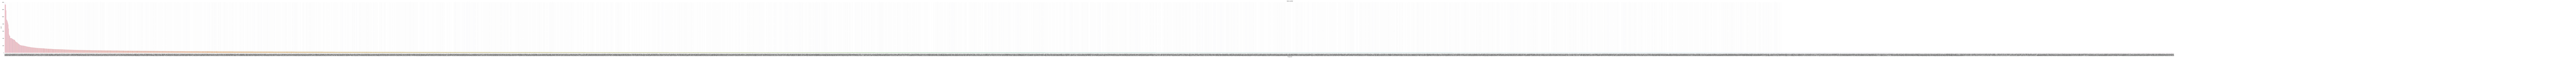

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

items_sorted = pd.DataFrame(train_x[:,:2], columns=[ "reviewerID","asin"]).groupby("asin").count().sort_values(by="reviewerID",ascending=False).reset_index()
items_sorted.asin = items_sorted.asin.astype(str)
sns.set_style("darkgrid")

def plot(df, title_name, figure_name, fig_size):
    plt.figure(figsize=(fig_size[0],fig_size[1]), dpi=100)
    plt.xticks(rotation=90)
    sns_plot = sns.barplot(data =df, x="asin", y="reviewerID")
    sns_plot.set(xlabel='Product ID', ylabel='count',title=title_name)
    
    sns_plot.figure.savefig(figure_name)


In [56]:
print(items_sorted.shape)
plot(items_sorted.head(1000), title_name= "Items sorted", figure_name="top1000_items", fig_size=[100,20])
plot(items_sorted.head(10), title_name= "Items sorted", figure_name="top10_items", fig_size=[15,10])
plot(items_sorted, title_name= "Items sorted", figure_name="train_items_sorted", fig_size=[500,10])

,asin,reviewerID
0,15023,1342
1,15021,1341
2,14612,1338
3,15256,1179
4,14521,926
5,14526,906
6,15028,877
7,14513,839
8,15349,789
9,17337,676


In [50]:
from scipy.stats import rankdata

def get_popularity_recommendations(items_sorted):
  return items_sorted.asin.to_numpy()

popularity_recommendations = get_popularity_recommendations(items_sorted)
popularity_recommendations[:10]

array(['15023', '15021', '14612', '15256', '14521', '14526', '15028',
       '14513', '15349', '17337'], dtype=object)

In [57]:
from scipy.stats import rankdata

def get_popularity_recommendations(train_x, dims):

  train_x_rank = np.insert(np.array(train_x), train_x.shape[1], rankdata(train_x[:,-1]), 1)
  pop_rec = train_x[train_x_rank[:,-1].argsort()[::-1]][:,1]- dims[0]
  pop_rec = [i for n, i in enumerate(pop_rec) if i not in pop_rec[:n]] 
  
  return np.hstack(pop_rec)

popularity_recommendations = get_popularity_recommendations(train_x, dims)
popularity_recommendations[:10] + dims[0]


array([18904, 18524, 14526, 18964, 19679, 19680, 20108, 18541, 18584,
       14360])

In [33]:
top10_rec = popularity_recommendations[:10] +dims[0]
top10_rec

array([18904, 18524, 14526, 18964, 19679, 19680, 20108, 18541, 18584,
       14360])

In [20]:
train_x, rating_mat = ng_sample(train_x, dims)
print("Dimensions matrix:\n",dims)
print("\nRating matrix:")
rating_mat

BUILDING ADJACENCY MATRIX...: 100%|██████████| 123226/123226 [00:10<00:00, 11952.54it/s]
perform negative sampling...: 123226it [00:06, 19093.67it/s]


Dimensions matrix:
 [14138 20316]

Rating matrix:


<20316x20316 sparse matrix of type '<class 'numpy.float32'>'
	with 347600 stored elements in Dictionary Of Keys format>

In [21]:
dims[-1]-dims[0]

6178

In [22]:
# Exercise 2

## Evaristo
#### number of ones
print(np.count_nonzero(rating_mat.toarray())/(dims[-1]*dims[-1]))
### number of zeros
print(1 - np.count_nonzero(rating_mat.toarray())/(dims[-1]*dims[-1]))

# ## Brenda
# #### Who sparse is the matrix??
# print(1 - rating_mat.shape[0] / rating_mat.count_nonzero())

0.0008421769667914019
0.9991578230332085


In [23]:
train_x = train_x[:,[0,1,-1]]

In [24]:
train_x[:10]

array([[    0, 19248,     1],
       [    0, 14547,     0],
       [    0, 20139,     0],
       [    0, 19680,     0],
       [    0, 18083,     0],
       [    0, 19249,     1],
       [    0, 15410,     0],
       [    0, 20082,     0],
       [    0, 16041,     0],
       [    0, 19078,     0]])

# Creating dataset class

In [25]:
class PointData(Dataset):
    def __init__(self,
                 data: np.ndarray,
                 dims: list) -> None:
        """
        Dataset formatter adapted point-wise algorithms
        Parameters
        """
        super(PointData, self).__init__()
        self.interactions = data
        self.dims = dims

    def __len__(self) -> int:
        return len(self.interactions)
        
    def __getitem__(self, 
                    index: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Return the pairs user-item and the target.
        """
        return self.interactions[index][:-1], self.interactions[index][-1]

train_dataset = PointData(train_x, dims)

In [26]:
train_dataset[0]

(array([    0, 19248]), 1)

# Preparing the test set for inference

In [27]:
test_x

array([[    0, 17249,     5],
       [    1, 18015,     5],
       [    2, 14196,     4],
       ...,
       [14135, 19938,     5],
       [14136, 20214,     2],
       [14137, 15542,     3]])

In [28]:
import math
print(rating_mat.shape)
bits = math.ceil(math.log(rating_mat.shape[0],2))
print("rating_mat contains log2(rating_mat.shape[0]) = {} bits".format(bits))

(20316, 20316)
rating_mat contains log2(rating_mat.shape[0]) = 15 bits


In [29]:
# def create_test_no_interactions(train_x: np.ndarray, test_x: np.ndarray, dims_usuarios_productos: Tuple[int, int],  num_samples: int) -> np.ndarray:
#     """
#     Esta funcion se encarga de crear de manera eficiente un dataset que contenga las interacciones usuario-producto en test que no se hayan producido.
    
#     Argumentos:
#         train_x (np.ndarray): matriz de entrenamiento con las interacciones usuario-producto previas
#         test_x (np.ndarray): matriz de prueba con las interacciones usuario-producto previas
#         dims_usuarios_productos (Tuple[int, int]): rango de productos y usuarios disponibles
    
#     Retorno:
#         np.ndarray: una matriz con todas las interacciones usuario-producto en test que no se hayan producido
#     """
#     from tqdm import tqdm
#     import random
    
#     # Identificamos los usuarios presentes en la prueba
#     usuarios_test = np.unique(test_x[:, 0])
#     # Identificamos el rango de productos disponibles
#     total_productos = range(dims_usuarios_productos[0]-1, dims_usuarios_productos[1])
    
#     # Recorremos cada usuario presente en la prueba
#     for usuario in tqdm(usuarios_test):
#         # Identificamos los productos en los que el usuario ha interactuado previamente en entrenamiento
#         productos_train = np.unique(train_x[train_x[:, 0] == usuario][:, 1])
#         # Seleccionamos al azar 199 productos con los que el usuario no ha interactuado previamente
#         productos_a_machear = random.choices(list(set(total_productos) - set(productos_train)), k=num_samples)
#         # Creamos una lista de interacciones usuario-producto para este usuario
#         # lista_por_usuario = [[usuario, x] for x in productos_a_machear]
#         # We must avoid using for loops!
#         lista_por_usuario = np.vstack([(np.ones(len(productos_a_machear))*usuario).astype(int), productos_a_machear]).T
        
#         # Si es el primer usuario, inicializamos una matriz con sus interacciones
#         if usuario == 0:
#             zero_positions = lista_por_usuario
#         # Si no es el primer usuario, concatenamos sus interacciones a la matriz existente
#         else:
#             zero_positions = np.concatenate((zero_positions, lista_por_usuario), axis=0)
            
#     return zero_positions

In [30]:
def ng_test(rating_mat):
    # save_data_configuration("\n"+"#"*4+"  zero_positions: all data  "+"#"*4)
    # return np.asarray(np.where(rating_mat.A==0)).T
    zero_true_matrix = np.where(rating_mat.A==0)
    save_data_configuration("\n"+"#"*4+"  zero_positions: all data separated by rows  "+"#"*4)
    return np.asarray([zero_true_matrix[0],zero_true_matrix[1]]).T

In [31]:
# zero_positions = np.asarray(np.where(rating_mat.A==0)).T
zero_positions = ng_test(rating_mat)
print(save_data_configuration(str(zero_positions.shape)+"\n"))
zero_positions

(412392256, 2)



array([[    0,     0],
       [    0,     1],
       [    0,     2],
       ...,
       [20315, 20313],
       [20315, 20314],
       [20315, 20315]], dtype=int64)

In [32]:
import time
def items_to_compute(zero_positions, dims):

    # LAB
    # items2compute = []
    # for user in trange(dims[0]):
    #     aux = zero_positions[zero_positions[:, 0] == user][:, 1]
    #     items2compute.append(aux[aux >= dims[0]])
    # items2compute[0]

    # # ANTONIO
    # mask = zero_positions[:, 1] >= dims[0]
    # # Seleccionar los valores de la columna 1 que cumplen la condición
    # zero_positions = zero_positions[mask]
    # # Supongamos que el array se llama 'arr'
    # usuarios = zero_positions[:, 0]
    # lista_longitud_zeros = np.bincount(usuarios, minlength=len(set(usuarios)))
    # # Crear lista de sublistas vacías de acuerdo a la lista de longitudes
    # list_of_lists = [list() for i in range(len(lista_longitud_zeros))]
    # for i, length in enumerate(lista_longitud_zeros):
    #     # Agregar ceros a cada sublista
    #     list_of_lists[i] = [0]*length
    # # Convertir lista de sublistas a un array de NumPy
    # items2compute = np.array([np.array(x) for x in list_of_lists])
    # for user in trange(dims[0]):
    #     aux = zero_positions[zero_positions[:, 0] == user][:, 1]
    #     # Asignar los elementos necesarios a cada usuario
    #     items2compute[user] = aux.copy()
    #     # 3%|▎         | 421/14138 [03:01<1:38:46,  2.31it/s]

    # JOAN
    # items2compute = []
    # items_zero_per_user = []
    # for user in trange(dims[0]):
    #     aux1 = rating_mat[user, (dims[0]+1):]        
    #     items_zero_per_user = np.where(aux1.A==0)  # devuelve los indices
    #     aux = items_zero_per_user[:] + (dims[0]+1) # le sumamos la dimension para ubicar correctamente la columna
    #     aux = aux[1]
    #     # lista items del user en train del mismo usuario que tengan rating 0 ó 1
    #     items_train_user = train_x[train_x[:,0]==user][:,1]
    #     # los retiramos del test (los 1 como no existen no se retiran, solo eliminan los 0)
    #     aux = list(set(aux) - set(items_train_user))
    #     items2compute.append(sorted(aux)) # añadimos los valores de item

    # BRENDA
    zp_df = pd.DataFrame(zero_positions[zero_positions[:, 1] >= dims[0]], columns=['u','i'])
    zp_df_index_u = zp_df.set_index(['u']) # 55 seg
    users = np.unique(zero_positions[:,0]) # 50 seg
    print(zp_df_index_u)
    print(zp_df_index_u.shape)

    items2compute = list(list() for _ in users)
    for i in trange(len(users)):
        items2compute[i] = np.hstack(zp_df_index_u.loc[i].to_numpy())
    # 100%|██████████| 20316/20316 [02:44<00:00, 123.50it/s]

    return items2compute

items2compute = items_to_compute(zero_positions, dims)


           i
u           
0      14138
0      14139
0      14140
0      14141
0      14142
...      ...
20315  20311
20315  20312
20315  20313
20315  20314
20315  20315

[125370541 rows x 1 columns]
(125370541, 1)


100%|██████████| 20316/20316 [02:27<00:00, 138.01it/s]


In [33]:
test_x

array([[    0, 17249,     5],
       [    1, 18015,     5],
       [    2, 14196,     4],
       ...,
       [14135, 19938,     5],
       [14136, 20214,     2],
       [14137, 15542,     3]])

In [34]:
def build_test_set(itemsnoninteracted:list, gt_test_interactions: np.ndarray) -> list:
    #max_users, max_items = dims # number users (943), number items (2625)
    test_set = []
    for pair, negatives in tqdm(zip(gt_test_interactions, itemsnoninteracted), desc="BUILDING TEST SET..."):
        # APPEND TEST SETS FOR SINGLE USER
        negatives = np.delete(negatives, np.where(negatives == pair[1]))
        single_user_test_set = np.vstack([pair, ] * (len(negatives)+1))
        single_user_test_set[:, 1][1:] = negatives
        test_set.append(single_user_test_set.copy())
    return test_set

test_x = build_test_set(items2compute, test_x[:,:2])
test_x[0]

BUILDING TEST SET...: 14138it [01:52, 125.67it/s]


array([[    0, 17249],
       [    0, 14138],
       [    0, 14139],
       ...,
       [    0, 20313],
       [    0, 20314],
       [    0, 20315]])

## Pickle DUMP

In [35]:
# Guarda train_dataset y test_x
import pickle
from datetime import date
today = date.today()
mod_path = execution_path / Path("4_Modelling/mod_baseline")
os.makedirs(mod_path, exist_ok=True)
timestamp = today.strftime("%dday%mmon%Yyear")

# Train
with open(mod_path / f"MOD_baseline_train_{timestamp}.pkl", 'wb') as handle:
    pickle.dump(train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test
with open(mod_path / f"MOD_baseline_test_{timestamp}.pkl", 'wb') as f:
    pickle.dump(test_x, f)

with open(mod_path / f"MOD_baseline_popRec_{timestamp}.pkl", 'wb') as f:
    pickle.dump(popularity_recommendations, f)


## Pickle LOAD

In [ ]:
# # Guarda train_dataset y test_x
# import pickle
# from datetime import date
# import os

# mod_path = execution_path / Path("4_Modelling/mod_baseline")
# assert os.path.exists(mod_path), f"The following path does not exist: \n{mod_path}"
# timestamp = "{d}day{m}mon{y}year".format(d="04", m="03", y="2023")

# # Train
# with open(mod_path / f"MOD_baseline_train_{timestamp}.pkl", 'rb') as handle:
#     train_dataset = pickle.load(handle)

# # Test
# with open(mod_path / f"MOD_baseline_test_{timestamp}.pkl", 'rb') as f:
#     test_x = pickle.load(handle)


# Building Factorization Machines model

In [36]:
class FM_operation(torch.nn.Module):

    def __init__(self, 
                 reduce_sum: bool=True) -> None:
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self,
                x: torch.Tensor) -> float:
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        # square_of_sum = np.sum(x, dim=1) ** 2 # ...
        # sum_of_square = np.sum(x ** 2, dim=1) # ...
        
        square_of_sum = torch.pow(torch.sum(x, dim=1),2)
        sum_of_square = torch.sum(torch.pow(x,2), dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix
        

In [37]:
class FactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Factorization Machine.

    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, 
                 field_dims: list,
                 embed_dim: float) -> None:
        super().__init__()
        self.linear = torch.nn.Linear(len(field_dims), 1)
        self.embedding = torch.nn.Embedding(field_dims[-1], embed_dim)
        self.fm = FM_operation(reduce_sum=True)

        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, interaction_pairs: torch.Tensor) -> torch.Tensor:
        """
        :param interaction_pairs: Long tensor of size ``(batch_size, num_fields)``
        """
        out = self.linear(interaction_pairs.float()) + self.fm(self.embedding(interaction_pairs))
        return out.squeeze(1)
        
    def predict(self, 
                interactions: np.ndarray,
                device: torch.device) -> torch.Tensor:
        # return the score, inputs are numpy arrays, outputs are tensors
        test_interactions = torch.from_numpy(interactions).to(dtype=torch.long, device=device) #, dtype=torch.long)
        output_scores = self.forward(test_interactions)
        return output_scores

# Pipeline functions

## Training

In [38]:
from statistics import mean

def train_one_epoch(model: torch.nn.Module,
                    optimizer: torch.optim,
                    data_loader: torch.utils.data.DataLoader,
                    criterion: torch.nn.functional,
                    device: torch.device) -> float:
    model.train()
    total_loss = []

    for i, (interactions, targets) in enumerate(data_loader):
        interactions = interactions.to(device)
        targets = targets.to(device)

        predictions = model(interactions[:,:2])
    
        loss = criterion(predictions, targets.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

    return mean(total_loss)

# Define metrics

In [39]:
import math

def getHitRatio(recommend_list: list,
                gt_item: int) -> bool:
    if gt_item in recommend_list:
        return 1
    else:
        return 0

def getNDCG(recommend_list: list,
            gt_item: int) -> float:
    idx = np.where(recommend_list == gt_item)[0]
    if len(idx) > 0:
        return math.log(2)/math.log(idx+2)
    else:
        return 0

# Inference


In [40]:
def test(model: torch.nn.Module,
         test_x: np.ndarray,
         device: torch.device,
         topk: int=10) -> Tuple[float, float]:
    # Test the HR and NDCG for the model @topK
    model.eval()

    user_recommend_list = np.zeros(len(test_x)).tolist()
    index = 0

    HR, NDCG = [], []
    for user_test in test_x:
        gt_item = user_test[0][1]
        predictions = model.predict(user_test, device)
        _, indices = torch.topk(predictions, topk)
        recommend_list = user_test[indices.cpu().detach().numpy()][:, 1]
        user_recommend_list[index] = recommend_list.tolist().copy()
        index +=1

        HR.append(getHitRatio(recommend_list, gt_item))
        NDCG.append(getNDCG(recommend_list, gt_item))
        
    coverage = len(set(np.hstack(user_recommend_list))) / (dims[1]-dims[0]) *100
    
    return mean(HR), mean(NDCG), user_recommend_list, coverage

In [41]:
def test_pop(model: torch.nn.Module,
         test_x: np.ndarray,
         device: torch.device,
         topk: int=10) -> Tuple[float, float]:
    # Test the HR and NDCG for the model @topK
    model.eval()

    user_recommend_list = np.zeros(len(test_x)).tolist()
    index = 0

    HR, NDCG = [], []
    for user_test in test_x:
        gt_item = user_test[0][1]
        predictions = model.predict(user_test, device)
        # print(predictions)
        # _, indices = torch.topk(predictions, topk)
        # print(indices)
        # print(user_test)
        recommend_list = predictions[:topk]
        # user_test[indices.cpu().detach().numpy()][:, 1]
        # print(recommend_list)
        user_recommend_list[index] = np.hstack(recommend_list.tolist().copy())
        index +=1

        HR.append(getHitRatio(recommend_list, gt_item))
        NDCG.append(getNDCG(recommend_list, gt_item))
        
    coverage = len(set(np.hstack(user_recommend_list))) / (dims[1]-dims[0]) *100
    
    return mean(HR), mean(NDCG), user_recommend_list, coverage

# PIPELINE
## Defining the model, the loss and the optimizer



In [42]:
dims = train_dataset.dims
model = FactorizationMachineModel(dims, hparams['hidden_size']).to(device)

criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=hparams['learning_rate'])

## Random evaluation

In [43]:
import random
class RandomModel(torch.nn.Module):
    def __init__(self, 
                 dims: list) -> None:
        super(RandomModel, self).__init__()
        """
        Simple random based recommender system
        """
        self.all_items = list(range(dims[0], dims[1]))

    def forward(self) -> None:
        pass

    def predict(self,
                interactions: np.ndarray,
                device=None) -> torch.Tensor:
        return torch.FloatTensor(random.sample(self.all_items, len(interactions)))

rnd_model = RandomModel(dims)

## Popularity evaluation

In [44]:
# Popularity-Based Recommender System
class PopularityBasedModel(torch.nn.Module):
  """
  https://github.com/LaxmiChaudhary/Amzon-Product-Recommendation/blob/master/Recommendation%20System.ipynb
  The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.
  We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both.
  """
  def __init__(self, 
                 popularity_recommendations) -> None:
        super(PopularityBasedModel, self).__init__()
        """
        Simple random based recommender system
        """
        self.popularity_recommendations = popularity_recommendations
  
  def predict(self,
              interactions: np.ndarray,
              device=None) -> torch.Tensor:
      return torch.IntTensor(self.popularity_recommendations)

pop_model = PopularityBasedModel(popularity_recommendations)

## NCF evaluation

In [ ]:
# class NCF(torch.nn.Module): #  with FactorizationMachine
#     def __init__(self, 
#                  field_dims: list,
#                  embed_dim: float) -> None:
#         super().__init__()
#         self.embed_dim = embed_dim
#         self.embedding = torch.nn.Embedding(field_dims[-1], embed_dim)
#         self.model_MF = FactorizationMachineModel(field_dims, embed_dim)
#         self.fm = FM_operation()
#         self.mlp = torch.nn.Sequential(torch.nn.Linear(len(field_dims), 1)


#         )
#         sequential = [[64, 16], # (8, )
#               [16, 32],
#               [32, 8],
#               [8, embed_dim]] 
#         self.last_fc = torch.nn.Linear(9, 1)
#         self.mlp = torch.nn.Sequential(torch.nn.Linear(64, 32),
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(32, 16),
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(16, 8),
#                         #   torch.nn.ReLU(),
#                         #   torch.nn.Linear(sequential[3][0], sequential[3][1]),
#                           torch.nn.ReLU())
#         self.linear = torch.nn.Linear(len(field_dims), 1)
#     def FactorizationMachine(self, interaction_pairs): # SI FUNCIONA, IMPLEMENTAR FactrizationMachineModel
#         return self.linear(interaction_pairs.float()) + self.fm(self.embedding(interaction_pairs))

#     def forward(self, interaction_pairs: torch.Tensor) -> torch.Tensor:
#         user = torch.from_numpy(interaction_pairs[:,0]).to(dtype=torch.long, device=device)
#         items = torch.from_numpy(interaction_pairs[:,1]).to(dtype=torch.long, device=device)
#         inter_tensor = torch.from_numpy(interaction_pairs).to(dtype=torch.long, device=device)

#         item_embedding_mlp = self.embedding(items)
#         user_embedding_mlp = self.embedding(user)
#         # print(interaction_pairs, interaction_pairs.shape)


#         mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
#         # mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)     # No usamos MatrixFactorization
#         # print("mf_vector.shape", mf_vector.shape)                       # No usamos MatrixFactorization
# #        print("mlp_vector.shape", mlp_vector.shape)
#         fm_vector = self.FactorizationMachine(inter_tensor)
# #        print("fm_vector.shape", fm_vector.shape)

#         mlp_vector = self.mlp(mlp_vector)
# #       print("mlp_vector.shape after MLP sequence", mlp_vector.shape)
# #        print("embedd dim: ", self.embed_dim)
#         concatenation= torch.cat([mlp_vector, fm_vector], dim=-1)
# #        print("concatenation.shape", concatenation.shape)
#         concatenation = self.last_fc(concatenation)
# #        print("Concatenation after Linear(9,1).shape", concatenation.shape)
       
        
#         return concatenation.squeeze()

#     def predict(self,
#                 interactions: np.ndarray,
#                 device: torch.device) -> torch.Tensor:
        
#         output_scores = self.forward(interactions)
#         return output_scores

# ncf_model = NCF(dims, hparams['hidden_size']).to(device)


In [ ]:
class NCF(torch.nn.Module):
    def __init__(self, 
                 field_dims: list,
                 embed_dim: float) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = torch.nn.Embedding(field_dims[-1], embed_dim)
        sequential = [[self.embed_dim*2, 32], [32, 16], [16, 8]]
        self.mlp = torch.nn.Sequential(
                        torch.nn.Linear(sequential[0][0], sequential[0][1]), #  (64, 32)
                        torch.nn.ReLU(),
                        torch.nn.Linear(sequential[1][0], sequential[1][1]),
                        torch.nn.ReLU(),
                        torch.nn.Linear(sequential[2][0], sequential[2][1]),
                        torch.nn.ReLU())
        self.last_fc = torch.nn.Linear(sequential[2][1]+self.embed_dim, 1)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, interaction_pairs: np.ndarray) -> torch.Tensor:
        user_embedding_mf = self.embedding(interaction_pairs[:,0])
        item_embedding_mf = self.embedding(interaction_pairs[:,1])

        # MLP vector reshaped to 2 dimensions
        mlp_vector = self.embedding(interaction_pairs)  # (6142, 2, 32)
        mlp_vector = mlp_vector.reshape(-1, self.embed_dim*2) # (6142, 64)

        # MatrixFactorization vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf) # ( _ , 32)

        # MLP thought layers
        mlp_vector = self.mlp(mlp_vector) # ( _ , sequential[2][1]) = ( _ , 8)

        # NCF: concat MLP_output and MF_output
        # NCF: Last fully connected layer of size (40x1) --> (8: mlp output + 32: mf output => 40)
        # NCF: Activation function ReLU
        concatenation = torch.cat([mlp_vector, mf_vector], dim=-1) # (_, 40)
        concatenation = self.last_fc(concatenation)
        # concatenation = self.relu(concatenation)
        return concatenation.squeeze()

    def predict(self,
                interactions: np.ndarray,
                device: torch.device) -> torch.Tensor:
        test_interactions = torch.from_numpy(interactions).to(dtype=torch.long, device=device)
        output_scores = self.forward(test_interactions)
        return output_scores

ncf_model = NCF(dims, hparams['hidden_size']).to(device)

## Final pipeline

In [45]:
data_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)

# Start training the model

In [ ]:
# DO EPOCHS NOW
from datetime import datetime
import time
save_data_configuration(datetime.now().strftime("%d-%b-%Y  %H:%M"))
time_start = time.time()
topk = 10

fm = np.zeros([hparams['num_epochs'],3])
rnd = np.zeros([hparams['num_epochs'],3])
pop = np.zeros([hparams['num_epochs'],3])
ncf = np.zeros([hparams['num_epochs'],3])

for epoch_i in range(hparams['num_epochs']):
    #data_loader.dataset.negative_sampling()
    train_loss = train_one_epoch(model, optimizer, data_loader, criterion, device)

    hr, ndcg, recommend_list_fm, cov_fm = test(model, test_x, device, topk=topk)
    print(save_data_configuration(f'MODEL: FACTORIZATION MACHINE'))
    print(save_data_configuration(f'epoch {epoch_i}:'))
    print(save_data_configuration(f'training loss = {train_loss:.4f} | Eval: HR@{topk} = {hr:.4f}, NDCG@{topk} = {ndcg:.4f} '))
    fm[epoch_i] = [hr, ndcg, cov_fm]
    tb_fm.add_scalar('train/loss', train_loss, epoch_i)
    tb_fm.add_scalar(f'eval/HR@{topk}', hr, epoch_i)
    tb_fm.add_scalar(f'eval/NDCG@{topk}', ndcg, epoch_i)

    hr, ndcg, recommend_list_rnd, cov_rnd = test(rnd_model, test_x, device, topk=topk)
    print(save_data_configuration(f'MODEL: RANDOM'))
    print(save_data_configuration(f'epoch {epoch_i}:'))
    print(save_data_configuration(f'training loss = {train_loss:.4f} | Eval: HR@{topk} = {hr:.4f}, NDCG@{topk} = {ndcg:.4f} '))
    rnd[epoch_i] = [hr, ndcg, cov_rnd]
    tb_rnd.add_scalar(f'eval/HR@{topk}', hr, epoch_i)
    tb_rnd.add_scalar(f'eval/NDCG@{topk}', ndcg, epoch_i)

    hr, ndcg, recommend_list_pop, cov_pop = test_pop(pop_model, test_x, device, topk=topk)
    print(save_data_configuration(f'MODEL: POPULARITY-BASED'))
    print(save_data_configuration(f'epoch {epoch_i}:'))
    print(save_data_configuration(f'training loss = {train_loss:.4f} | Eval: HR@{topk} = {hr:.4f}, NDCG@{topk} = {ndcg:.4f} '))
    pop[epoch_i] = [hr, ndcg, cov_pop]
    tb_pop.add_scalar(f'eval/HR@{topk}', hr, epoch_i)
    tb_pop.add_scalar(f'eval/NDCG@{topk}', ndcg, epoch_i)

    hr, ndcg, recommend_list_ncf, cov_ncf = test(ncf_model, test_x, device, topk=topk)
    print(save_data_configuration(f'MODEL: NEURAL COLLABORATIVE FILTERING'))
    print(save_data_configuration(f'epoch {epoch_i}:'))
    print(save_data_configuration(f'training loss = {train_loss:.4f} | Eval: HR@{topk} = {hr:.4f}, NDCG@{topk} = {ndcg:.4f} '))
    ncf[epoch_i] = [hr, ndcg, cov_ncf]
    tb_pop.add_scalar(f'eval/HR@{topk}', hr, epoch_i)
    tb_pop.add_scalar(f'eval/NDCG@{topk}', ndcg, epoch_i)

    save_data_configuration("_"*65)
 
save_data_configuration(f"# Training duration: {(time.time()-time_start):.4f}")

In [ ]:
# # DO EPOCHS NOW
# from datetime import datetime
# save_data_configuration(datetime.now().strftime("%d-%b-%Y  %H:%M"))
# time_start = time.time()
# topk = 10
# for epoch_i in range(hparams['num_epochs']):
#     #data_loader.dataset.negative_sampling()
#     train_loss = train_one_epoch(model, optimizer, data_loader, criterion, device)
#     hr, ndcg, recommend_list_fm, cov_fm = test(model, test_x, device, topk=topk)
    
#     print(save_data_configuration(f'MODEL: FACTORIZATION MACHINE'))
#     print(save_data_configuration(f'epoch {epoch_i}:'))
#     print(save_data_configuration(f'training loss = {train_loss:.4f} | Eval: HR@{topk} = {hr:.4f}, NDCG@{topk} = {ndcg:.4f} '))
 
#     tb_fm.add_scalar('train/loss', train_loss, epoch_i)
#     tb_fm.add_scalar(f'eval/HR@{topk}', hr, epoch_i)
#     tb_fm.add_scalar(f'eval/NDCG@{topk}', ndcg, epoch_i)

#     hr, ndcg, recommend_list_rnd, cov_rnd = test(rnd_model, test_x, device, topk=topk)

#     print(save_data_configuration(f'MODEL: RANDOM'))
#     print(save_data_configuration(f'epoch {epoch_i}:'))
#     print(save_data_configuration(f'training loss = {train_loss:.4f} | Eval: HR@{topk} = {hr:.4f}, NDCG@{topk} = {ndcg:.4f} '))
    
#     tb_rnd.add_scalar(f'eval/HR@{topk}', hr, epoch_i)
#     tb_rnd.add_scalar(f'eval/NDCG@{topk}', ndcg, epoch_i)

#     hr, ndcg, recommend_list_pop, cov_pop = test_pop(pop_model, test_x, device, topk=topk)
    
#     tb_pop.add_scalar(f'eval/HR@{topk}', hr, epoch_i)
#     tb_pop.add_scalar(f'eval/NDCG@{topk}', ndcg, epoch_i)

#     # save_data_configuration("_"*65)
#     print(save_data_configuration(f'MODEL: POPULARITY-BASED'))
#     print(save_data_configuration(f'epoch {epoch_i}:'))
#     print(save_data_configuration(f'training loss = {train_loss:.4f} | Eval: HR@{topk} = {hr:.4f}, NDCG@{topk} = {ndcg:.4f} '))
#     save_data_configuration("_"*65)
 
# save_data_configuration(f"# Training duration: {(time.time()-time_start):.4f}")

In [47]:
print(f"Coverage from FM: {cov_fm}")
print(f"Coverage from RAND: {cov_rnd}")
print(f"Coverage from POP: {cov_pop}")


Coverage from FM: 5.924247329232761
Coverage from RAND: 100.0
Coverage from POP: 0.16186468112657817


# Visualization

In [48]:
# os.chdir(os.getcwd() / Path("4_Modelling"))


In [49]:
# %tensorboard --logdir run_tensorboard